In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pyfolio as pf
from collections import OrderedDict
import sklearn.covariance

import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False
import warnings
warnings.filterwarnings('ignore')

In [2]:
commodity_pairs = pd.read_csv('./plots/commodity portfolio returns table.csv')
exchange_pairs = pd.read_csv('./plots/Exchange portfolio returns table.csv')
exchange_pairs=exchange_pairs.fillna(1)
dta = commodity_pairs.merge(exchange_pairs, left_on='Date', right_on='Date',how='inner')
dta['Date'] =pd.to_datetime(dta['Date']) 
dta = dta.set_index('Date')

In [4]:
# helper functions to estimate robust covariance and correlation matrices

def cov2cor(X):
    D = np.zeros_like(X)
    d = np.sqrt(np.diag(X))
    np.fill_diagonal(D, d)
    DInv = np.linalg.inv(D)
    R = np.dot(np.dot(DInv, X), DInv)
    return R

def cov_robust(X):
    oas = sklearn.covariance.OAS()
    oas.fit(X)
    return pd.DataFrame(oas.covariance_, index=X.columns, columns=X.columns)
    
def corr_robust(X):
    cov = cov_robust(X).values
    shrunk_corr = cov2cor(cov)
    return pd.DataFrame(shrunk_corr, index=X.columns, columns=X.columns)

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def mean_variance(returns, cov=None, shrink_means=False):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 50
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    if cov is None:
        S = opt.matrix(np.cov(returns))
    else:
        S = opt.matrix(cov)
    
    if shrink_means:
        pbar = opt.matrix(np.ones(cov.shape[0]))
    else:
        pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt)

def get_mean_variance(returns, cov):
    try: 
        w = mean_variance(returns.values, cov=cov.values)[:, 0]
    except:
        w = np.empty(cov.shape[0])
        w[:] = np.nan
        
    return w

def get_min_variance(returns, cov):
    try: 
        w = mean_variance(returns.values, cov=cov.values, shrink_means=True)[:, 0]
    except:
        w = np.empty(cov.shape[0])
        w[:] = np.nan
        
    return w

def tail_ratio(returns):
    """Determines the ratio between the right (95%) and left tail (5%).
    For example, a ratio of 0.25 means that losses are four times
    as bad as profits.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    Returns
    -------
    float
        tail ratio
    """

    return np.abs(np.percentile(returns, 95)) / \
        np.abs(np.percentile(returns, 5))

In [5]:
##NOT RAn
#!/usr/bin/env python
# On 20130210, v0.2
# Critical Line Algorithm
# by MLdP <lopezdeprado@lbl.gov>
import numpy as np
#---------------------------------------------------------------
#---------------------------------------------------------------
class CLA:
    def __init__(self,mean,covar,lB,uB):
        # Initialize the class
        if (mean==np.ones(mean.shape)*mean.mean()).all():mean[-1,0]+=1e-5
        self.mean=mean
        self.covar=covar
        self.lB=lB
        self.uB=uB
        self.w=[] # solution
        self.l=[] # lambdas
        self.g=[] # gammas
        self.f=[] # free weights
#---------------------------------------------------------------
    def solve(self):
        # Compute the turning points,free sets and weights
        f,w=self.initAlgo()
        self.w.append(np.copy(w)) # store solution
        self.l.append(None)
        self.g.append(None)
        self.f.append(f[:])
        while True:
            #1) case a): Bound one free weight
            l_in=None
            if len(f)>1:
                covarF,covarFB,meanF,wB=self.getMatrices(f)
                covarF_inv=np.linalg.inv(covarF)
                j=0
                for i in f:
                    l,bi=self.computeLambda(covarF_inv,covarFB,meanF,wB,j,[self.lB[i],self.uB[i]])
                    if l>l_in:l_in,i_in,bi_in=l,i,bi
                    j+=1
            #2) case b): Free one bounded weight
            l_out=None
            if len(f)<self.mean.shape[0]:
                b=self.getB(f)
                for i in b:
                    covarF,covarFB,meanF,wB=self.getMatrices(f+[i])
                    covarF_inv=np.linalg.inv(covarF)
                    l,bi=self.computeLambda(covarF_inv,covarFB,meanF,wB,meanF.shape[0]-1, \
                        self.w[-1][i])
                    if (self.l[-1]==None or l<self.l[-1]) and l>l_out:l_out,i_out=l,i                
            if (l_in==None or l_in<0) and (l_out==None or l_out<0):
                #3) compute minimum variance solution
                self.l.append(0)
                covarF,covarFB,meanF,wB=self.getMatrices(f)
                covarF_inv=np.linalg.inv(covarF)
                meanF=np.zeros(meanF.shape)
            else:
                #4) decide lambda
                if l_in>l_out:
                    self.l.append(l_in)
                    f.remove(i_in)
                    w[i_in]=bi_in # set value at the correct boundary
                else:
                    self.l.append(l_out)
                    f.append(i_out)
                covarF,covarFB,meanF,wB=self.getMatrices(f)
                covarF_inv=np.linalg.inv(covarF)
            #5) compute solution vector
            wF,g=self.computeW(covarF_inv,covarFB,meanF,wB)
            for i in range(len(f)):w[f[i]]=wF[i]
            self.w.append(np.copy(w)) # store solution
            self.g.append(g)
            self.f.append(f[:])
            if self.l[-1]==0:break
        #6) Purge turning points
        self.purgeNumErr(10e-10)
        self.purgeExcess()
#---------------------------------------------------------------    
    def initAlgo(self):
        # Initialize the algo
        #1) Form structured array
        a=np.zeros((self.mean.shape[0]),dtype=[('id',int),('mu',float)])
        b=[self.mean[i][0] for i in range(self.mean.shape[0])] # dump array into list
        a[:]=zip(range(self.mean.shape[0]),b) # fill structured array
        #2) Sort structured array
        b=np.sort(a,order='mu')
        #3) First free weight
        i,w=b.shape[0],np.copy(self.lB)
        while sum(w)<1:
            i-=1
            w[b[i][0]]=self.uB[b[i][0]]
        w[b[i][0]]+=1-sum(w)
        return [b[i][0]],w
#---------------------------------------------------------------    
    def computeBi(self,c,bi):
        if c>0:
            bi=bi[1][0]
        if c<0:
            bi=bi[0][0]
        return bi
#---------------------------------------------------------------
    def computeW(self,covarF_inv,covarFB,meanF,wB):
        #1) compute gamma
        onesF=np.ones(meanF.shape)
        g1=np.dot(np.dot(onesF.T,covarF_inv),meanF)
        g2=np.dot(np.dot(onesF.T,covarF_inv),onesF)
        if wB==None:
            g,w1=float(-self.l[-1]*g1/g2+1/g2),0
        else:
            onesB=np.ones(wB.shape)
            g3=np.dot(onesB.T,wB)
            g4=np.dot(covarF_inv,covarFB)
            w1=np.dot(g4,wB)
            g4=np.dot(onesF.T,w1)
            g=float(-self.l[-1]*g1/g2+(1-g3+g4)/g2)
        #2) compute weights
        w2=np.dot(covarF_inv,onesF)
        w3=np.dot(covarF_inv,meanF)
        return -w1+g*w2+self.l[-1]*w3,g
#---------------------------------------------------------------
    def computeLambda(self,covarF_inv,covarFB,meanF,wB,i,bi):
        #1) C
        onesF=np.ones(meanF.shape)
        c1=np.dot(np.dot(onesF.T,covarF_inv),onesF)
        c2=np.dot(covarF_inv,meanF)
        c3=np.dot(np.dot(onesF.T,covarF_inv),meanF)
        c4=np.dot(covarF_inv,onesF)
        c=-c1*c2[i]+c3*c4[i]
        if c==0:return None,None
        #2) bi
        if type(bi)==list:bi=self.computeBi(c,bi)
        #3) Lambda
        if wB==None:
            # All free assets
            return float((c4[i]-c1*bi)/c),bi
        else:
            onesB=np.ones(wB.shape)
            l1=np.dot(onesB.T,wB)
            l2=np.dot(covarF_inv,covarFB)
            l3=np.dot(l2,wB)
            l2=np.dot(onesF.T,l3)
            return float(((1-l1+l2)*c4[i]-c1*(bi+l3[i]))/c),bi
#---------------------------------------------------------------
    def getMatrices(self,f):
        # Slice covarF,covarFB,covarB,meanF,meanB,wF,wB
        covarF=self.reduceMatrix(self.covar,f,f)
        meanF=self.reduceMatrix(self.mean,f,[0])
        b=self.getB(f)
        covarFB=self.reduceMatrix(self.covar,f,b)
        wB=self.reduceMatrix(self.w[-1],b,[0])
        return covarF,covarFB,meanF,wB
#---------------------------------------------------------------
    def getB(self,f):
        return self.diffLists(range(self.mean.shape[0]),f)
#---------------------------------------------------------------
    def diffLists(self,list1,list2):
        return list(set(list1)-set(list2))
#---------------------------------------------------------------
    def reduceMatrix(self,matrix,listX,listY):
        # Reduce a matrix to the provided list of rows and columns
        matrix = np.asarray(matrix)
        if len(listX)==0 or len(listY)==0:return
        matrix_=matrix[:,listY[0]:listY[0]+1]
        for i in listY[1:]:
            a=matrix[:,i:i+1]
            matrix_=np.append(matrix_,a,1) # gets stuck
        matrix__=matrix_[listX[0]:listX[0]+1,:]
        for i in listX[1:]:
            a=matrix_[i:i+1,:]
            matrix__=np.append(matrix__,a,0)
        return matrix__
#---------------------------------------------------------------    
    def purgeNumErr(self,tol):
        # Purge violations of inequality constraints (associated with ill-conditioned covar matrix)
        i=0
        while True:
            flag=False
            if i==len(self.w):break
            if abs(sum(self.w[i])-1)>tol:
                flag=True
            else:
                for j in range(self.w[i].shape[0]):
                    if self.w[i][j]-self.lB[j]<-tol or self.w[i][j]-self.uB[j]>tol:
                        flag=True;break
            if flag==True:
                del self.w[i]
                del self.l[i]
                del self.g[i]
                del self.f[i]
            else:
                i+=1
        return
#---------------------------------------------------------------    
    def purgeExcess(self):
        # Remove violations of the convex hull
        i,repeat=0,False
        while True:
            if repeat==False:i+=1
            if i==len(self.w)-1:break
            w=self.w[i]
            mu=np.dot(w.T,self.mean)[0,0]
            j,repeat=i+1,False
            while True:
                if j==len(self.w):break
                w=self.w[j]
                mu_=np.dot(w.T,self.mean)[0,0]
                if mu<mu_:
                    del self.w[i]
                    del self.l[i]
                    del self.g[i]
                    del self.f[i]
                    repeat=True
                    break
                else:
                    j+=1
        return
#---------------------------------------------------------------
    def getMinVar(self):
        # Get the minimum variance solution
        var=[]
        for w in self.w:
            a=np.dot(np.dot(w.T,self.covar),w)
            var.append(a)
        return min(var)**.5,self.w[var.index(min(var))]
#---------------------------------------------------------------
    def getMaxSR(self):
        # Get the max Sharpe ratio portfolio
        #1) Compute the local max SR portfolio between any two neighbor turning points
        w_sr,sr=[],[]
        for i in range(len(self.w)-1):
            w0=np.copy(self.w[i])
            w1=np.copy(self.w[i+1])
            kargs={'minimum':False,'args':(w0,w1)}
            a,b=self.goldenSection(self.evalSR,0,1,**kargs)
            w_sr.append(a*w0+(1-a)*w1)
            sr.append(b)
        return max(sr),w_sr[sr.index(max(sr))]
#---------------------------------------------------------------
    def evalSR(self,a,w0,w1):
        # Evaluate SR of the portfolio within the convex combination
        w=a*w0+(1-a)*w1
        b=np.dot(w.T,self.mean)[0,0]
        c=np.dot(np.dot(w.T,self.covar),w)[0,0]**.5
        return b/c
#---------------------------------------------------------------
    def goldenSection(self,obj,a,b,**kargs):
        # Golden section method. Maximum if kargs['minimum']==False is passed 
        from math import log,ceil
        tol,sign,args=1.0e-9,1,None
        if 'minimum' in kargs and kargs['minimum']==False:sign=-1
        if 'args' in kargs:args=kargs['args']
        numIter=int(ceil(-2.078087*log(tol/abs(b-a))))
        r=0.618033989
        c=1.0-r
        # Initialize
        x1=r*a+c*b;x2=c*a+r*b
        f1=sign*obj(x1,*args);f2=sign*obj(x2,*args)
        # Loop
        for i in range(numIter):
            if f1>f2:
                a=x1
                x1=x2;f1=f2
                x2=c*a+r*b;f2=sign*obj(x2,*args)
            else:
                b=x2
                x2=x1;f2=f1
                x1=r*a+c*b;f1=sign*obj(x1,*args)
        if f1<f2:return x1,sign*f1
        else:return x2,sign*f2
#---------------------------------------------------------------
    def efFrontier(self,points):
        # Get the efficient frontier
        mu,sigma,weights=[],[],[]
        a=np.linspace(0,1,points/len(self.w))[:-1] # remove the 1, to avoid duplications
        b=range(len(self.w)-1)
        for i in b:
            w0,w1=self.w[i],self.w[i+1]
            if i==b[-1]:a=np.linspace(0,1,points/len(self.w)) # include the 1 in the last iteration
            for j in a:
                w=w1*j+(1-j)*w0
                weights.append(np.copy(w))
                mu.append(np.dot(w.T,self.mean)[0,0])
                sigma.append(np.dot(np.dot(w.T,self.covar),w)[0,0]**.5)
        return mu,sigma,weights
#---------------------------------------------------------------
#---------------------------------------------------------------

In [6]:
import scipy.cluster.hierarchy as sch
import random
import numpy as np
import pandas as pd

def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index

    return sortIx.tolist()


def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2),
                                                      (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w


def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist




def generateData(nObs, sLength, size0, size1, mu0, sigma0, sigma1F):
    # Time series of correlated variables
    # 1) generate random uncorrelated data
    x = np.random.normal(mu0, sigma0, size=(nObs, size0))
    # each row is a variable
    # 2) create correlation between the variables
    cols = [random.randint(0, size0 - 1) for i in range(size1)]
    y = x[:, cols] + np.random.normal(0, sigma0 * sigma1F, size=(nObs, len(cols)))
    x = np.append(x, y, axis=1)
    # 3) add common random shock
    point = np.random.randint(sLength, nObs - 1, size=2)
    x[np.ix_(point, [cols[0], size0])] = np.array([[-.5, -.5], [2, 2]])
    # 4) add specific random shock
    point = np.random.randint(sLength, nObs - 1, size=2)

    x[point, cols[-1]] = np.array([-.5, 2])

    return x, cols


def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    corr, cov = pd.DataFrame(corr), pd.DataFrame(cov)
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    # recover labels
    hrp = getRecBipart(cov, sortIx)

    return hrp.sort_index()


def getCLA(cov, **kargs):
    # Compute CLA's minimum variance portfolio
    mean = np.arange(cov.shape[0]).reshape(-1, 1)
    # Not used by C portf
    lB = np.zeros(mean.shape)
    uB = np.ones(mean.shape)
    cla = CLA(mean, cov, lB, uB)
    cla.solve()
    return cla.w[-1].flatten()


def hrpMC(numIters=10000, nObs=520, size0=5, size1=5, mu0=0, sigma0=1e-2,
          sigma1F=.25, sLength=260, rebal=22):
    # Monte Carlo experiment on HRP
    methods = {'getHRP': getHRP, 'getIVP': getIVP, 'getCLA': getCLA}
    stats = {k: pd.Series() for k in methods.keys()}
    
    pointers = range(sLength, nObs, rebal)
    for numIter in range(int(numIters)):
        # print numIter
        # 1) Prepare data for one experiment
        x, cols = generateData(nObs, sLength, size0,
                               size1, mu0, sigma0, sigma1F)
        r = pd.DataFrame(columns=[methods.keys()],
                         index=range(sLength, nObs))#{i.__name__: pd.Series() for i in methods}
        #print r
        # 2) Compute portfolios in-sample
        for pointer in pointers:
            x_ = x[pointer - sLength:pointer]
            cov_ = np.cov(x_, rowvar=0)
            corr_ = np.corrcoef(x_, rowvar=0)
            # 3) Compute performance out-of-sample
            x_ = x[pointer:pointer + rebal]
            for name, func in methods.iteritems():
                w_ = func(cov=cov_, corr=corr_)
                # callback
                #r_ = pd.Series(np.dot(x_, w_))
                #print r[name].append(r_)
                #print pointer
                r.loc[pointer:pointer + rebal - 1, name] = np.dot(x_, w_)

        # 4) Evaluate and store results
        for name, func in methods.iteritems():
            r_ = r[name].reset_index(drop=True)
            p_ = (1 + r_).cumprod()
            stats[name].loc[numIter] = p_.iloc[-1] - 1  # terminal return

    # 5) Report results
    stats = pd.DataFrame.from_dict(stats, orient='columns')
    # stats.to_csv('stats.csv')
    df0, df1 = stats.std(), stats.var()
    print (pd.concat([df0, df1, df1 / df1['getHRP'] - 1], axis=1))
    return stats

In [7]:
rets = dta.pct_change()

In [8]:
symbols = list(dta.columns)

In [9]:
# There has to be a more succinct way to do this using rolling_apply or resample
# Would love to see a better version of this.
eoms = rets.resample('1BM').index[13:-1]
covs = pd.Panel(items=eoms, minor_axis=rets.columns, major_axis=rets.columns)
corrs = pd.Panel(items=eoms, minor_axis=rets.columns, major_axis=rets.columns)
covs_robust = pd.Panel(items=eoms, minor_axis=rets.columns, major_axis=rets.columns)
corrs_robust = pd.Panel(items=eoms, minor_axis=rets.columns, major_axis=rets.columns)
for eom in eoms:
    rets_slice = rets.loc[eom-pd.Timedelta('252d'):eom]
    covs.loc[eom] = rets_slice.cov()
    corrs.loc[eom] = rets_slice.corr()
    covs_robust.loc[eom] = cov_robust(rets_slice)
    corrs_robust.loc[eom] = corr_robust(rets_slice)

In [ ]:
sklearn.covariance.OAS

In [10]:
portfolio_funcs = OrderedDict((
    ('Equal weighting', lambda returns, cov, corr: np.ones(cov.shape[0]) / len(cov.columns)),
    ('Inverse Variance weighting', lambda returns, cov, corr: getIVP(cov)),
    #('Minimum-variance (CLA) weighting', getCLA),
    ('Mean-Variance weighting', lambda returns, cov, corr: get_mean_variance(returns, cov)),
    ('Robust Mean-Variance weighting', lambda returns, cov, corr: get_mean_variance(returns, cov)),
    ('Min-Variance weighting', lambda returns, cov, corr: get_min_variance(returns, cov)),
    ('Robust Min-Variance weighting', lambda returns, cov, corr: get_min_variance(returns, cov)),        
    ('Hierarchical weighting (by LdP)', lambda returns, cov, corr: getHRP(cov, corr)),
    ('Robust Hierarchical weighting (by LdP)', lambda returns, cov, corr: getHRP(cov, corr)),
))

In [19]:
weights = pd.Panel(items=portfolio_funcs.keys(), major_axis=eoms, minor_axis=symbols, dtype=np.float32)
port_returns = pd.DataFrame(columns=portfolio_funcs.keys(), index=rets.index)

In [20]:
for name, portfolio_func in portfolio_funcs.items():
    w = pd.DataFrame(index=eoms, columns=symbols, dtype=np.float32)
    for idx in covs:
        if 'obust' in name:
            w.loc[idx] = portfolio_func(rets.loc[idx-pd.Timedelta('252d'):idx].T, 
                                        covs_robust.loc[idx],
                                        corrs_robust.loc[idx]
            )
        else:
            w.loc[idx] = portfolio_func(rets.loc[idx-pd.Timedelta('252d'):idx].T, 
                                        covs.loc[idx],
                                        corrs.loc[idx]
            )
    
    port_returns[name] = w.loc[rets.index].ffill().multiply(rets).sum(axis='columns')

    weights.loc[name, :, :] = w

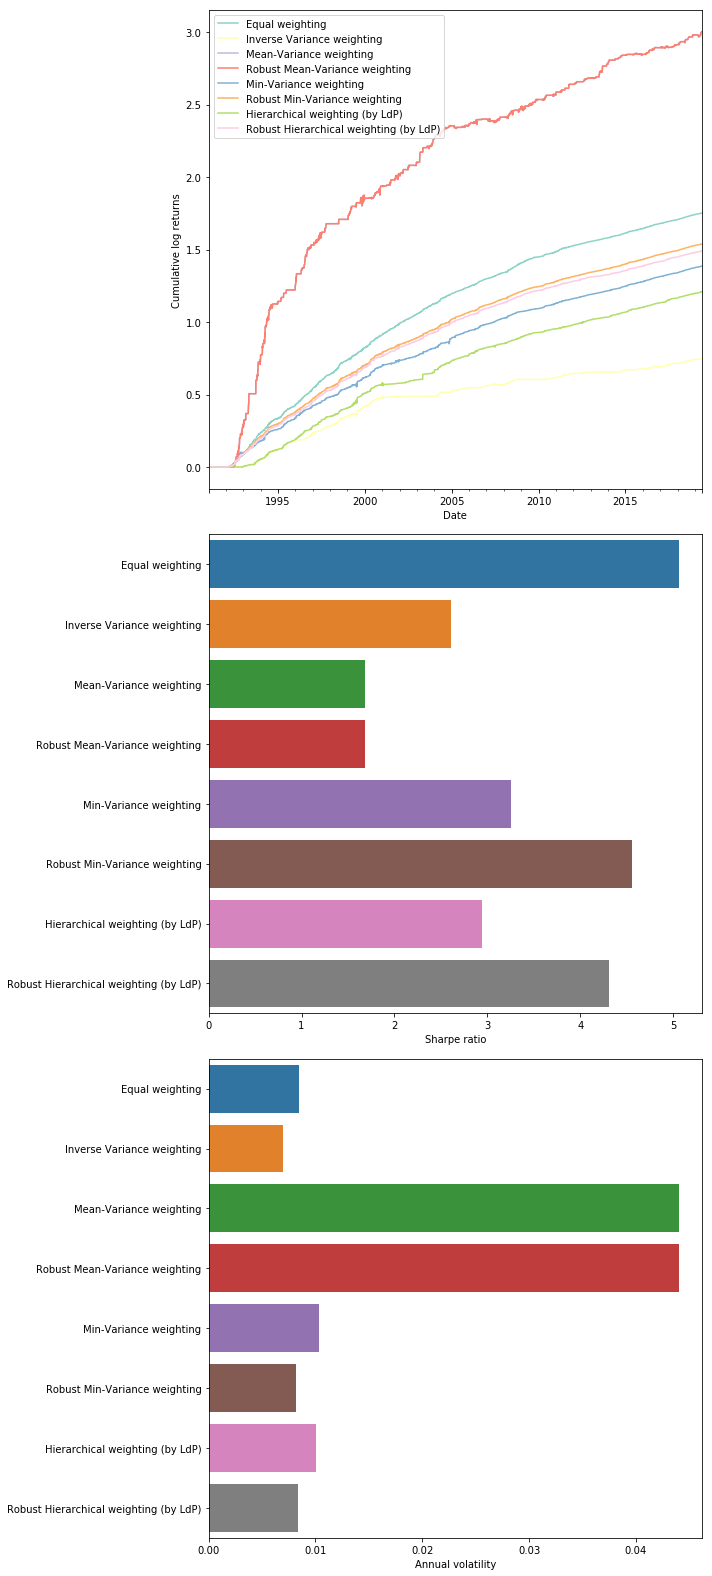

In [21]:
fig, axs = plt.subplots(nrows=3, figsize=(10, 22))
colors = sns.color_palette(palette='Set3', n_colors=len(port_returns))

for i, name in enumerate(port_returns):
    np.log1p(port_returns[name]).cumsum().plot(ax=axs[0], color=colors[i])
    
axs[0].legend(loc=0)
axs[0].set(ylabel='Cumulative log returns')



sharpes = port_returns.apply(pf.timeseries.sharpe_ratio)
sns.barplot(x=sharpes.values, y=sharpes.index, ax=axs[1])
axs[1].set(xlabel='Sharpe ratio')

vols = port_returns.apply(pf.timeseries.annual_volatility)
sns.barplot(x=vols.values, y=vols.index, ax=axs[2])
axs[2].set(xlabel='Annual volatility')

#cal = port_returns.apply(pf.timeseries.calmar_ratio)
#sns.barplot(x=cal.values, y=cal.index, ax=ax4)
#ax4.set(xlabel='Calmar Ratio')

#tr = port_returns.apply(tail_ratio)
#sns.barplot(x=tr.values, y=tr.index, ax=ax5)
#ax5.set(xlabel='Tail Ratio') 

# plot_ = axs[0]
# fig_ = plot_.get_figure()
# fig_.savefig("./plots/xxx.png")

fig.tight_layout()
fig.savefig("./plots/portfolio_weight_.png")

In [23]:
pd.Panel.to_frame(weights).to_csv('./plots/portfolio_ratios.csv')

In [27]:
port_returns.to_csv('./plots/portfolio_different_weight_return.csv')